# Laboratory Wоrk №2
## Demidova Anastasia   
## Group 17-AC  

### Option 5

In [23]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from scipy import interp
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
%config InlineBackend.figure_format = 'svg'
sns.set_style('whitegrid')

### Изучить набор данных
### Создать описание набора данных на русском языке 
### Описать признаки, используемые в наборе данных

| Переменная   | Описание  | Параметры(Ключи)  | 
|--------------|--------------|-------------------|
|pclass        |класс билета  |1 - 1 класс; 2 -  2 класс; 3 -  3 класс |
|survived| выживание| 0 - Нет ;1 - Да|
|name|имя|любой|
|sex|пол|female - женский, male - мужской|
|age|возраст|любой числовой|
|sibsp|число братьев, сестер, супругов на борту|любой числовой|
|parch|число родителей, детей на ботру|любой числовой|
|fare|цена билета(британский фунт)|любой числовой|
|ticket|номер билета|любой|
|cabin|номер каюты|любой|
|embarked|порт погрузки|C = Cherbourg, Q = Queenstown, S = Southampton|
|boat|номер спасательной шлюпки|любой|
|body|идентификационный номер тела|любой|
|home.dest|Дом/Назначение|любой|    

**Задача: по данным признакам предсказать, выживет ли пасажир.**     

In [5]:
df = pd.read_csv(r'titanic3.csv', sep=';')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29,0.0,0.0,24160,"211,3375",B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,"0,9167",1.0,2.0,113781,"151,5500",C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [7]:
list_to_drop = ['body', 'boat', 'name', 'cabin', 'ticket', 'home.dest']
df.drop(list_to_drop, axis=1, inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,29,0.0,0.0,"211,3375",S
1,1.0,1.0,male,"0,9167",1.0,2.0,"151,5500",S
2,1.0,0.0,female,2,1.0,2.0,"151,5500",S
3,1.0,0.0,male,30,1.0,2.0,"151,5500",S
4,1.0,0.0,female,25,1.0,2.0,"151,5500",S


###  Удалим дубликаты строк 

In [9]:
df = df.drop_duplicates()
print('dataset size', df.shape)
df.count()

dataset size (1115, 8)


pclass      1114
survived    1114
sex         1114
age          974
sibsp       1114
parch       1114
fare        1113
embarked    1112
dtype: int64

### Оценим сбалансированность данных по классам

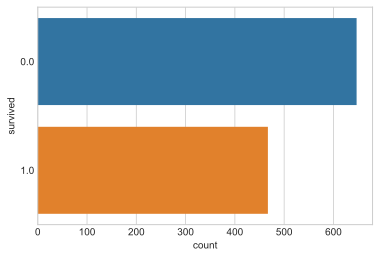

In [10]:
sns.countplot(data=df, y='survived')
plt.show()

Классы не сбалансированы. Будем использовать PR кривую

### Выполним масштабирование количественных признаков

In [13]:
def cast(obj):
    if type(obj) == str:
        return float(obj.replace(',', '.'))
    else:
        return obj
df['age'] = df['age'].apply(lambda x: cast(x))
df['fare'] = df['fare'].apply(lambda x: cast(x))
df['pclass'] = df['pclass'].apply(lambda x: str(x))

# выделим категориальные и числовые(количественные) признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']
print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['survived', 'age', 'sibsp', 'parch', 'fare']
categorial:  ['pclass', 'sex', 'embarked']


In [15]:
# заполним пропущенные значения параметра age медианными,
# чтобы не потерять много данных при очистке строк с пустыми полями
df['age'] = df['age'].fillna(df['age'].median())
df = df.dropna().reset_index(drop=True)
print('dataset size', df.shape)
df.count()

dataset size (1111, 8)


pclass      1111
survived    1111
sex         1111
age         1111
sibsp       1111
parch       1111
fare        1111
embarked    1111
dtype: int64

In [16]:
# нормализуем
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,0.361169,0.000,0.000000,0.412503,S
1,1.0,1.0,male,0.009395,0.125,0.222222,0.295806,S
2,1.0,0.0,female,0.022964,0.125,0.222222,0.295806,S
3,1.0,0.0,male,0.373695,0.125,0.222222,0.295806,S
4,1.0,0.0,female,0.311064,0.125,0.222222,0.295806,S


### Выполним замену категориальных признаков

In [17]:
# выделим бинарные и небинарные признаки
binary_columns = [i for i in categorial_columns if len(df[i].unique()) == 2]
nonbinary_columns = [i for i in categorial_columns if len(df[i].unique()) > 2]

# для бинарных заменим значения на 1 и 0
for col in binary_columns:
    for i, unic_item in enumerate(df[col].unique()):
        df[col] = df[col].replace(to_replace=[unic_item], value=[i])
        
# для не бинарых применим dummy-кодирование
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
df.drop(nonbinary_columns, axis=1, inplace=True)
df = pd.concat([df_nonbinary, df] , axis=1)

print(df.shape)
df.head()

(1111, 12)


,pclass_1.0,pclass_2.0,pclass_3.0,embarked_C,embarked_Q,embarked_S,survived,sex,age,sibsp,parch,fare
0,1,0,0,0,0,1,1.0,0,0.361169,0.000,0.000000,0.412503
1,1,0,0,0,0,1,1.0,1,0.009395,0.125,0.222222,0.295806
2,1,0,0,0,0,1,0.0,0,0.022964,0.125,0.222222,0.295806
3,1,0,0,0,0,1,0.0,1,0.373695,0.125,0.222222,0.295806
4,1,0,0,0,0,1,0.0,0,0.311064,0.125,0.222222,0.295806


### Оценим корреляцию между признаков и удалим те признаки, которые коррелируют с наибольшим числом

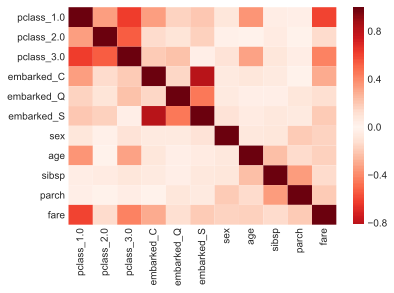

In [19]:
df_corr = df.drop('survived', axis=1).corr()
colors = sns.color_palette("Reds_r", n_colors=100)
colors += sns.color_palette("Reds", n_colors=100)
sns.heatmap(df_corr, cmap=colors, center=0)
plt.show()

### Заполним пропущенные значения

In [20]:
print('dataset size', df.shape)
df.count()

dataset size (1111, 12)


pclass_1.0    1111
pclass_2.0    1111
pclass_3.0    1111
embarked_C    1111
embarked_Q    1111
embarked_S    1111
survived      1111
sex           1111
age           1111
sibsp         1111
parch         1111
fare          1111
dtype: int64

### Решите поставленную задачу классификации в соответствии с заданием

- классификатор K ближайших соседей
- логический классификатор (бинарное решающее дерево)

In [21]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('survived', axis=1), df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

** Ближайшие соседи  - подбор параметров**

In [24]:
knn = KNeighborsClassifier()
params = {'n_neighbors': list(range(1, 50))}
knn_grid = GridSearchCV(knn, params)
knn_grid.fit(X_train, y_train)
best_num = knn_grid.best_estimator_.n_neighbors
best_score = knn_grid.best_score_

print('best train score: ', best_score,
      '\t at neighbors number: ', best_num)

rnc = KNeighborsClassifier(n_neighbors=best_num)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score:  0.788931788931789 	 at neighbors number:  19
test score:  0.769461077844


** Решающее дерево - подбор параметров **

In [25]:
dtc = DecisionTreeClassifier()

params = {'max_depth': list(range(1,12)), 'max_features': list(range(1,12))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 0.7812097812097812 	 at features number: 6 	 at depth: 5
test score:  0.784431137725


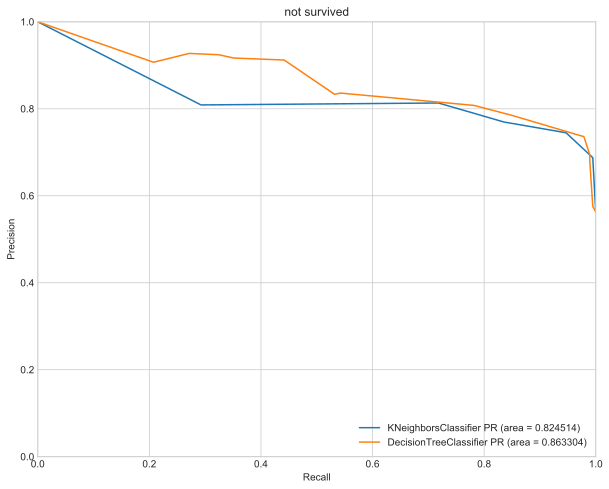

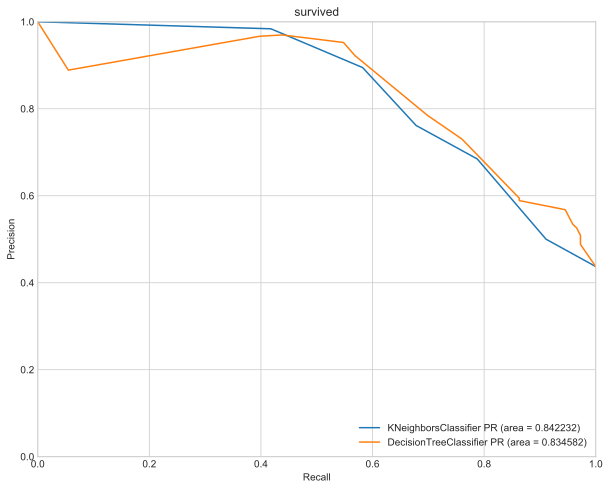

In [30]:
plt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
    
probas_knn0 = knn.fit(X_train, y_train).predict_proba (X_test)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba (X_test)
probas_knn1 = knn.fit(X_train, y_train).predict_proba (X_test)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_knn1[:,0])
aps_knn1 = average_precision_score(y_test_invers,probas_knn1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_dtc1[:,0])
aps_dtc1 = average_precision_score(y_test_invers,probas_dtc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('not survived')
plt.show()


plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test, probas_knn0[:,1])
aps_knn0 = average_precision_score(y_test,probas_knn0[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn0)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test, probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test,probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('survived')
plt.show()

### Вывод
Классификаторы дерево принятия решений и k ближайших соседей имеют примерно одинаковые показатели качества относительно PR и ROC кривых. В целом, данные классификаторы правильно решают задачу предсказания класса с вероятностью 0.8~0.85, что не слишком точно, но и далеко от случайного - 0.5 (т.к. классов всего 2). Поэтому задача классификации была решена.